In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Loading data
df = pd.read_csv('imdb-reviews_2.csv')
print(df['label'].value_counts())

# 1: Clean the text
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove non-alphabetic chars
    text = text.lower()
    text = ' '.join([w for w in text.split() if len(w) > 2])  # Remove short words
    return text

df['review_processed'] = df['review'].apply(clean_text)



label
1    2528
0    2472
Name: count, dtype: int64


In [5]:
# 2: Removing stopwords and custom words
stop_words = set(stopwords.words('english'))
custom_words = {'movie', 'film', 'one', 'make', 'even'}
all_stopwords = stop_words.union(custom_words)

df['review_processed'] = df['review_processed'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in all_stopwords])
)



In [6]:
# 3: Lemmatization with POS tagging
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return None

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmatized = []
    for word, tag in tagged:
        wn_tag = get_wordnet_pos(tag)
        if wn_tag:
            lemmatized.append(lemmatizer.lemmatize(word, wn_tag))
        else:
            lemmatized.append(word)
    return ' '.join(lemmatized)

df['review_processed'] = df['review_processed'].apply(lemmatize_text)

<ipython-input-7-f8631f1055aa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


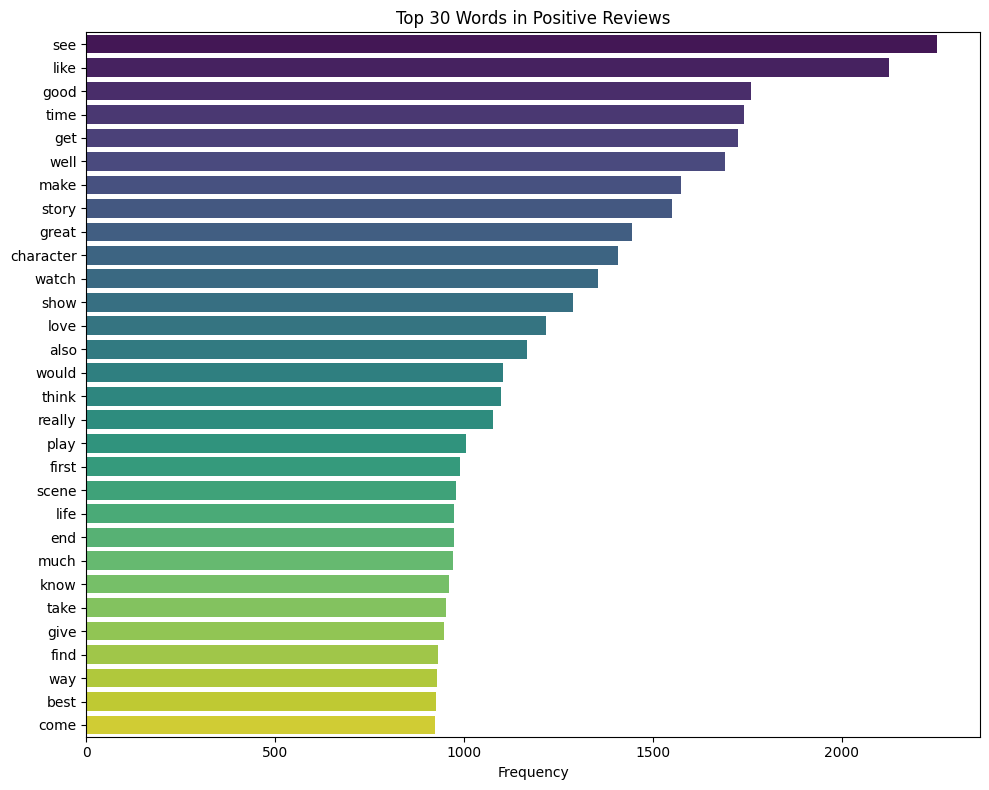

In [7]:
# 4: Most frequent words in positive reviews
positive_words = ' '.join(df[df['label'] == 1]['review_processed']).split()
pos_freq = Counter(positive_words).most_common(30)
words, freqs = zip(*pos_freq)

plt.figure(figsize=(10, 8))
sns.barplot(x=list(freqs), y=list(words), palette='viridis')
plt.title("Top 30 Words in Positive Reviews")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

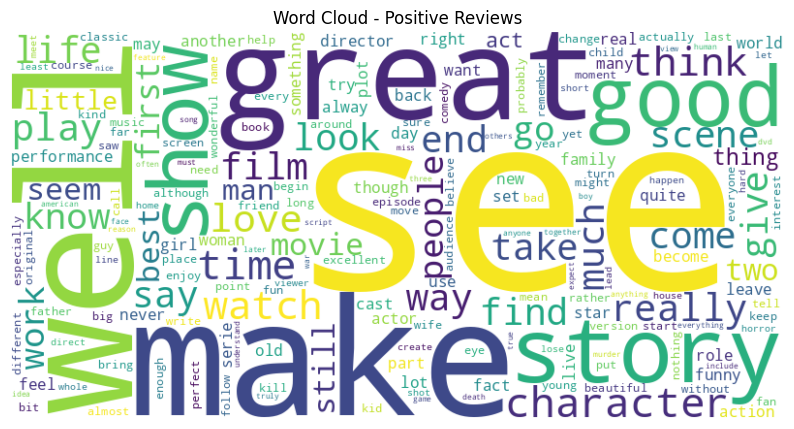

In [8]:
# 5: Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")
plt.show()

In [9]:
# 6: Vectorization and Train-Test Split
vectorizer = CountVectorizer(max_features=2500)
X = vectorizer.fit_transform(df['review_processed']).toarray()
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 7: GaussianNB Model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       479
           1       0.79      0.58      0.67       521

    accuracy                           0.70      1000
   macro avg       0.72      0.71      0.70      1000
weighted avg       0.72      0.70      0.70      1000



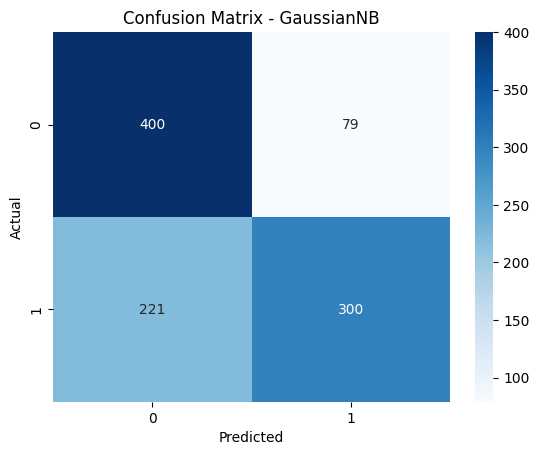

In [11]:
# 8: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - GaussianNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
# 9: Logistic Regression with various C values
for c in [0.01, 0.05, 0.5, 1]:
    logreg = LogisticRegression(C=c, max_iter=1000)
    logreg.fit(X_train, y_train)
    acc = logreg.score(X_test, y_test)
    print(f"Logistic Regression Accuracy (C={c}): {acc:.4f}")



Logistic Regression Accuracy (C=0.01): 0.8540
Logistic Regression Accuracy (C=0.05): 0.8570
Logistic Regression Accuracy (C=0.5): 0.8460
Logistic Regression Accuracy (C=1): 0.8360


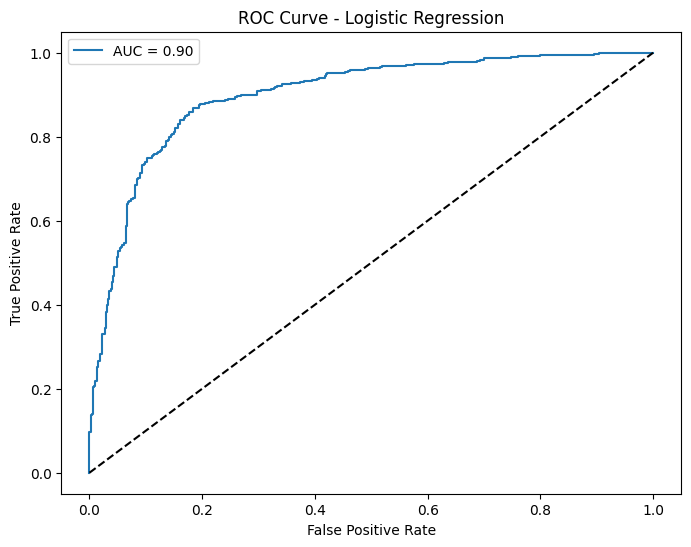

In [13]:
# 10: ROC Curve & AUC
logreg = LogisticRegression(C=1)
logreg.fit(X_train, y_train)
y_probs = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()